In [2]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pickle


In [3]:
data = pd.read_csv('../data/VesselSimulator/feature1.csv')
data.head()

,Dati,Time,DEPTH,ENGINE_1_FLOWTEMPA,ENGINE_1_FUEL_CONSUMPTION,ENGINE_2_FLOWTEMPA,ENGINE_2_FUEL_CONSUMPTION,HEADING,LATITUDE,LONGITUDE,...,snowfall,weathercode,is_weekday,wind_force,wind_direc,effective_wind_factor,effective_wind,resist_ratio1,resist_ratio2,adversarial
0,190830_022700,147.0,0.0049,25.6000,332.9910,25.6000,334.3725,176.4,49.1936,-123.9554,...,0.0,1,True,20.241001,2.0,0.954240,5.346895,0.002412,0.0,0
1,190830_022800,148.0,0.0037,25.6083,401.2981,25.6000,383.3828,179.7,49.1943,-123.9554,...,0.0,1,True,96.012562,1.0,0.178802,0.641006,0.001969,0.0,0
2,190830_022900,149.0,0.0158,25.7000,423.8546,25.6417,424.2150,186.9,49.1965,-123.9555,...,0.0,1,True,278.439282,0.0,-0.969872,-5.510522,0.001711,0.0,0
3,190830_023000,150.0,0.0206,25.7867,561.3356,25.7100,536.0195,215.1,49.1994,-123.9543,...,0.0,1,True,445.691210,0.0,-0.992757,-7.372911,0.001434,0.0,0
4,190830_023100,151.0,0.0215,25.9300,648.2187,25.8250,615.8354,232.2,49.2024,-123.9504,...,0.0,1,True,1002.317608,0.0,-0.949972,-14.854428,0.001337,0.0,0


In [4]:
data.columns

Index(['Dati', 'Time', 'DEPTH', 'ENGINE_1_FLOWTEMPA',
       'ENGINE_1_FUEL_CONSUMPTION', 'ENGINE_2_FLOWTEMPA',
       'ENGINE_2_FUEL_CONSUMPTION', 'HEADING', 'LATITUDE', 'LONGITUDE',
       'PITCH_1', 'PITCH_2', 'POWER_1', 'POWER_2', 'SOG', 'SOG_SPEEDLOG_LONG',
       'SOG_SPEEDLOG_TRANS', 'SPEED_1', 'SPEED_2', 'STW', 'THRUST_1',
       'THRUST_2', 'TORQUE_1', 'TORQUE_2', 'WIND_ANGLE', 'WIND_SPEED',
       'WIND_ANGLE_TRUE', 'WIND_SPEED_TRUE', 'trip_id', 'MODE', 'datetime',
       'season', 'weekday', 'current', 'direction', 'pressure', 'rain',
       'snowfall', 'weathercode', 'is_weekday', 'wind_force', 'wind_direc',
       'effective_wind_factor', 'effective_wind', 'resist_ratio1',
       'resist_ratio2', 'adversarial'],
      dtype='object')

In [5]:
# remove Time, Depth column
X = data.drop(['Time', 'DEPTH', 'Dati', 'TORQUE_1', 'TORQUE_2', 'THRUST_2', 'THRUST_1', 'SOG_SPEEDLOG_LONG', 'SOG_SPEEDLOG_TRANS'], axis=1)

# create a new column as ENGINE_1_FUEL_CONSUMPTION + ENGINE_2_FUEL_CONSUMPTION
X['SFC'] = X['ENGINE_1_FUEL_CONSUMPTION'] + X['ENGINE_2_FUEL_CONSUMPTION']
X['SPEED'] = X['SPEED_1'] + X['SPEED_2']
X['ENGINE_FLOWTEMPA'] = X['ENGINE_1_FLOWTEMPA'] + X['ENGINE_2_FLOWTEMPA']
X['PITCH'] = X['PITCH_1'] + X['PITCH_2']
X['POWER'] = X['POWER_1'] + X['POWER_2']
X['resist_ratio'] = X['resist_ratio1'] + X['resist_ratio2']


# filter only adverserial is 0
X = X[X['adversarial'] == 0]

X = X.drop(['ENGINE_1_FUEL_CONSUMPTION','ENGINE_2_FUEL_CONSUMPTION', 'adversarial', 'wind_direc', 'SPEED_1', 'SPEED_1',
            'ENGINE_1_FLOWTEMPA', 'ENGINE_2_FLOWTEMPA', 'PITCH_1', 'PITCH_2',
            'POWER_1', 'POWER_2', 'resist_ratio1', 'resist_ratio2'], axis=1)

# convert to datetime
X['datetime'] = pd.to_datetime(X['datetime'])


# convert direction to 1 if N-H other 0
X['direction'] = X['direction'].apply(lambda x: 1 if x == 'N-H' else 0)


# for each trip_id group, find the first 3 rows and last 3 rows of LATITUDE and LONGITUDE and return the mean for each group
X['LATITUDE_start'] = X.groupby('trip_id')['LATITUDE'].transform(lambda x: x.iloc[:3].mean() )
X['LATITUDE_end'] = X.groupby('trip_id')['LATITUDE'].transform(lambda x: x.iloc[-3:].mean())
X['LONGITUDE_start'] = X.groupby('trip_id')['LONGITUDE'].transform(lambda x: x.iloc[:3].mean() )
X['LONGITUDE_end'] = X.groupby('trip_id')['LONGITUDE'].transform(lambda x: x.iloc[-3:].mean())

# group by direction
LATITUDE_goal_1 = X.groupby('direction')['LATITUDE_start'].mean() 
LATITUDE_goal_2 = X.groupby('direction')['LATITUDE_end'].mean() 

LONGITUDE_goal_1 = X.groupby('direction')['LONGITUDE_start'].mean()
LONGITUDE_goal_2 = X.groupby('direction')['LONGITUDE_end'].mean()

LATITUDE_goal_0 = (LATITUDE_goal_1.iloc[0] + LATITUDE_goal_2.iloc[1])/2
LATITUDE_goal_1 = (LATITUDE_goal_1.iloc[1] + LATITUDE_goal_2.iloc[0])/2
LONGITUDE_goal_0 = (LONGITUDE_goal_1.iloc[0] + LONGITUDE_goal_2.iloc[1])/2
LONGITUDE_goal_1 = (LONGITUDE_goal_1.iloc[1] + LONGITUDE_goal_2.iloc[0])/2

X.drop(['LATITUDE_start', 'LATITUDE_end', 'LONGITUDE_start', 'LONGITUDE_end'], axis=1, inplace=True)

print(LATITUDE_goal_0, LATITUDE_goal_1, LONGITUDE_goal_0, LONGITUDE_goal_1)

X.rename(columns={'LATITUDE': 'LAT', 'LONGITUDE': 'LON'}, inplace=True)




49.3788352862298 49.19541486727186 -123.27131442779599 -123.9551366316478


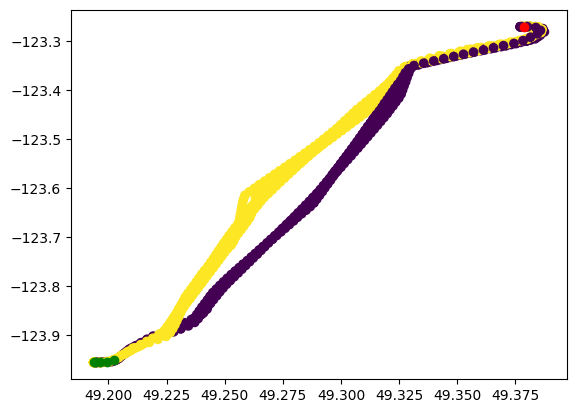

In [6]:
# plot the goal points and some datapoint in a scatter plot
import matplotlib.pyplot as plt
ax = plt.gca()
ax.scatter(X['LAT'][:1000], X['LON'][:1000], c=X['direction'][:1000])
ax.scatter(X[X['direction']==1]['LAT'][:5], X[X['direction']==1]['LON'][:5], c='g')
ax.scatter([LATITUDE_goal_0,  ], [LONGITUDE_goal_0, ], c='r')

In [7]:
# engineered 

# 1. features
# compute eucleadian distance to the goal
#  compute for direction 0 (X['direction']==0) which has LATITUDE_goal_1, LONGITUDE_goal_1
# and for direction 1 (X['direction']==1) which has LATITUDE_goal_0, LONGITUDE_goal_0
X['distance'] = np.sqrt((X[X['direction']==1]['LAT'] - LATITUDE_goal_0)**2 + (X[X['direction']==1]['LON'] - LONGITUDE_goal_0)**2)
X['distance'] = X['distance'].fillna(np.sqrt((X[X['direction']==0]['LAT'] - LATITUDE_goal_1)**2 + (X[X['direction']==0]['LON'] - LONGITUDE_goal_1)**2))
# compute time elapsed from the start using datetime colomn
X['elapsed_time'] = X.groupby('trip_id')['datetime'].transform(lambda x: (x - x.iloc[0]).dt.total_seconds())
# compute commuliative fuel consumption from the start
X['cumulative_SFC'] = X.groupby('trip_id')['SFC'].transform(lambda x: x.cumsum())

# create new column as start_trip and set it to True for the first elemet of trip_id that changes otherwise False
X['start_trip'] = X['trip_id'] != X['trip_id'].shift(1)

# previous output
X["PSFC"] = X['SFC'].shift(1)
X["PSOG"] = X['SPEED'].shift(1)
X["PLAT"] = X['LAT'].shift(1)
X["PLON"] = X['LON'].shift(1)

# for the first element of each trip_id, repeat the first element
X['PSFC'] = X.groupby('trip_id')['PSFC'].transform(lambda x: x.bfill())
X['PSOG'] = X.groupby('trip_id')['PSOG'].transform(lambda x: x.bfill())
X['PLAT'] = X.groupby('trip_id')['PLAT'].transform(lambda x: x.bfill())
X['PLON'] = X.groupby('trip_id')['PLON'].transform(lambda x: x.bfill())


# 2. output
# compute estimated arrival time (EAT) as the minutes to reach the end of trip
X['EAT'] = X.groupby('trip_id')['elapsed_time'].transform(lambda x: x.max() - x)
# outputs 'SFC', 'SOG', 'LAT', 'LON',  of one-step, two-step, three-step ahead
X['SFC_1'] = X.groupby('trip_id')['SFC'].shift(-1)
X['SFC_2'] = X.groupby('trip_id')['SFC'].shift(-2)
X['SFC_3'] = X.groupby('trip_id')['SFC'].shift(-3)
X['SOG_1'] = X.groupby('trip_id')['SPEED'].shift(-1)
X['SOG_2'] = X.groupby('trip_id')['SPEED'].shift(-2)
X['SOG_3'] = X.groupby('trip_id')['SPEED'].shift(-3)
X['LAT_1'] = X.groupby('trip_id')['LAT'].shift(-1)
X['LAT_2'] = X.groupby('trip_id')['LAT'].shift(-2)
X['LAT_3'] = X.groupby('trip_id')['LAT'].shift(-3)
X['LON_1'] = X.groupby('trip_id')['LON'].shift(-1)
X['LON_2'] = X.groupby('trip_id')['LON'].shift(-2)
X['LON_3'] = X.groupby('trip_id')['LON'].shift(-3)

# for the last two elements of each trip_id, repeat the last element
X['SFC_1']= X.groupby('trip_id')['SFC_1'].transform(lambda x: x.ffill())
X['SFC_2'] = X.groupby('trip_id')['SFC_2'].transform(lambda x: x.ffill())
X['SFC_3'] = X.groupby('trip_id')['SFC_3'].transform(lambda x: x.ffill())
X['SOG_1'] = X.groupby('trip_id')['SOG_1'].transform(lambda x: x.ffill())
X['SOG_2'] = X.groupby('trip_id')['SOG_2'].transform(lambda x: x.ffill())
X['SOG_3'] = X.groupby('trip_id')['SOG_3'].transform(lambda x: x.ffill())
X['LAT_1'] = X.groupby('trip_id')['LAT_1'].transform(lambda x: x.ffill())
X['LAT_2'] = X.groupby('trip_id')['LAT_2'].transform(lambda x: x.ffill())
X['LAT_3'] = X.groupby('trip_id')['LAT_3'].transform(lambda x: x.ffill())
X['LON_1'] = X.groupby('trip_id')['LON_1'].transform(lambda x: x.ffill())
X['LON_2'] = X.groupby('trip_id')['LON_2'].transform(lambda x: x.ffill())
X['LON_3'] = X.groupby('trip_id')['LON_3'].transform(lambda x: x.ffill())

# compute accumulative fuel consumption from now to reaching the goal
X['cf_SFC'] = X.groupby('trip_id')['SFC'].transform(lambda x: x.cumsum().iloc[-1] - x.cumsum())

In [8]:
# order the columns

# not very important features
# 'resist_ratio', 'rain', 'snowfall', 'weekday','season',
# repetitive features
# 'effective_wind', 'wind_force', 'WIND_SPEED_TRUE', 'WIND_ANGLE_TRUE'

X = X[[# action space [0,1,2]
        'SPEED', 'HEADING', 'MODE', 
        # measurements 
        # [3                 ,4      ,5       ,6      ,7          ,8]
        'ENGINE_FLOWTEMPA', 'PITCH', 'POWER', 'STW','WIND_ANGLE', 'WIND_SPEED', 
        # engineered features 
        # [9       ,10        ,11            ,12            ,13]
        'direction','distance', 'elapsed_time', 'cumulative_SFC',
        # disturbances 
        # [14    ,15         ,16            ,17           ,18]
        'current', 'pressure', 'weathercode', 'is_weekday', 'effective_wind_factor',
        # previous output 
        # [19    ,20         ,21    ,22]
        'PSFC', 'PSOG', 'PLAT', 'PLON',
        # output (to be removed)
        # [23  , 24 , 25, 26]
        'SFC', 'SOG', 'LAT', 'LON',
        # [27, 28]
        'EAT', 'cf_SFC',
        # [29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
        'SFC_1', 'SFC_2', 'SFC_3', 'SOG_1', 'SOG_2', 'SOG_3', 'LAT_1', 'LAT_2', 'LAT_3', 'LON_1', 'LON_2', 'LON_3', 
         # to be removed
         'datetime','start_trip','trip_id'
       ]]

In [9]:
# compute average duration of the trip for each direction
X.groupby(['trip_id', 'direction'])['direction'].count().groupby('direction').max()



direction
0    119
1    143
Name: direction, dtype: int64

In [10]:
X['datetime'].min(), X['datetime'].max()

(Timestamp('2019-08-30 04:54:00'), Timestamp('2021-10-01 00:38:00'))

In [11]:
# convert to two df, one for data before 2021-01-01, one for data after 2021-01-01

X1 = X[X['datetime'] < '2021-05-01']
X2 = X[X['datetime'] >= '2021-05-01']  # 5 month for test

In [12]:
feature_columns = X1.columns[:22] 
feature_columns

Index(['SPEED', 'HEADING', 'MODE', 'ENGINE_FLOWTEMPA', 'PITCH', 'POWER', 'STW',
       'WIND_ANGLE', 'WIND_SPEED', 'direction', 'distance', 'elapsed_time',
       'cumulative_SFC', 'current', 'pressure', 'weathercode', 'is_weekday',
       'effective_wind_factor', 'PSFC', 'PSOG', 'PLAT', 'PLON'],
      dtype='object')

In [13]:
output_columns = X1.columns[22:-3]
output_columns

Index(['SFC', 'SOG', 'LAT', 'LON', 'EAT', 'cf_SFC', 'SFC_1', 'SFC_2', 'SFC_3',
       'SOG_1', 'SOG_2', 'SOG_3', 'LAT_1', 'LAT_2', 'LAT_3', 'LON_1', 'LON_2',
       'LON_3'],
      dtype='object')

In [14]:
X1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 217412 entries, 0 to 243723
Data columns (total 43 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   SPEED                  217412 non-null  float64       
 1   HEADING                217412 non-null  float64       
 2   MODE                   217412 non-null  float64       
 3   ENGINE_FLOWTEMPA       217412 non-null  float64       
 4   PITCH                  217412 non-null  float64       
 5   POWER                  217412 non-null  float64       
 6   STW                    217412 non-null  float64       
 7   WIND_ANGLE             217412 non-null  float64       
 8   WIND_SPEED             217412 non-null  float64       
 9   direction              217412 non-null  int64         
 10  distance               217412 non-null  float64       
 11  elapsed_time           217412 non-null  float64       
 12  cumulative_SFC         217412 non-null  float64  

In [15]:
# standardize the data with min-max scaler
scaler = MinMaxScaler()
# create augmented X1, X2 dataframe
df_aug = pd.concat([X1[X1.columns[:-3]], X2[X2.columns[:-3]]], ignore_index=True)
scaler.fit(df_aug)
X1_scaled = scaler.transform(X1[X1.columns[:-3]])
X2_scaled = scaler.transform(X2[X2.columns[:-3]])

# replace the scaled one with the original and make the last three columns unchanged
X1[X1.columns[:-3]] = X1_scaled
X2[X2.columns[:-3]] = X2_scaled



/tmp/ipykernel_676960/2092156096.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X1[X1.columns[:-3]] = X1_scaled
/tmp/ipykernel_676960/2092156096.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2[X2.columns[:-3]] = X2_scaled


In [16]:
# transform to numpy array
X1_start_trip = X1[X1['start_trip'] == True].iloc[:, :-3]
X2_start_trip = X2[X2['start_trip'] == True].iloc[:, :-3]

X1_start_trip = scaler.transform(X1_start_trip)
X2_start_trip = scaler.transform(X2_start_trip)

start_trip = {'X1': X1_start_trip, 'X2': X2_start_trip}

# save to pickle start_trip
with open('../data/VesselSimulator/start_trip.pkl', 'wb') as f:
    pickle.dump(start_trip, f)

scaler = {'scaler': scaler}
# save the scaler_X and scaler_Y
with open('../data/VesselSimulator/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

X1 = X1.drop(['datetime', 'start_trip'], axis=1)
X2 = X2.drop(['datetime', 'start_trip'], axis=1)



In [17]:
def create_dataset(df, feature_columns, output_columns):
    """
    Converts a DataFrame into a numpy array suitable for sequential models with padding.
    
    Args:
        df (pd.DataFrame): Input DataFrame with trip data
        feature_columns (list): List of feature column names.
        output_columns (list): List of output column names.
    
    Returns:
        np.ndarray: A numpy array of shape (num_trips, max_sequence_length, num_features).
        np.ndarray: A numpy array of (num_trips, max_sequence_length, num_outputs).
    """
    # Group by trip ID
    grouped = df.groupby("trip_id")
    
    # Determine max sequence length
    max_sequence_length = grouped.size().max()
    num_features = len(feature_columns)
    num_outputs = len(output_columns)
    
    # Prepare array: num_trips x max_sequence_length x (features + outputs)
    num_trips = len(grouped)
    inp = np.zeros((num_trips, max_sequence_length, num_features+1)) # +1 for done
    out = np.zeros((num_trips, max_sequence_length, num_outputs))
    
    # Populate the numpy array
    # create a feature as done = 1 when the sequence is finished otherwise 0
    # pad with zeros for the rest of the sequence
    for i, (trip_id, group) in enumerate(grouped):
        inp[i, :len(group),1:] = group[feature_columns].values
        out[i, :len(group), :] = group[output_columns].values
        inp[i, len(group):, 0] = 1  # done

    
    return inp, out

In [18]:
inp, out = create_dataset(X1, feature_columns, output_columns)

In [19]:
inp.shape

(2100, 143, 23)

In [20]:
out.shape

(2100, 143, 18)

In [21]:
inpt, outt = create_dataset(X2, feature_columns, output_columns)

In [22]:
# save as pickle
with open('../data/VesselSimulator/data_train.pkl', 'wb') as f:
    pickle.dump({'train': {'inp': inp, 'out': out}, 'test': {'inp': inpt, 'out': outt}}, f)